In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pickle
from IPython.display import clear_output

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

sns.set_context("talk")
sns.set_style("white")

def get_count_map(ds):
    dsc = ds.copy()
    group_keys = ds[ds.columns[1:-3]]
    dsc['duplicate_group_id'], _ = pd.factorize(group_keys.apply(tuple, axis=1))
    dsc_ = dsc.groupby(['pid'], as_index=False).duplicate_group_id.value_counts()
    dsc__ = dsc[['run', 'pid', 'duplicate_group_id']].merge(dsc_, on=['pid', 'duplicate_group_id'], how='left')[['run', 'pid', 'count']]
    return dsc__

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']
model_name = mydict['model_name']
model_name_short = model_name.split('/')[-1].lower()

In [3]:
resu = {}

In [4]:
# link to desired concept of truth
# truth = truth[['run', 'pid', 'correct', 'hallucinated']]
truth = truth[['run', 'pid', 'correct', 'hallucinated']]
truth.columns = ['run', 'pid', 'correct', 'hallucinated']

In [5]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [6]:
# decode perplexities (for later use)
ae = aggrodue[['pid', 'perplexity_l_10']].explode('perplexity_l_10').reset_index(drop=True)
ae['run'] = ae.groupby('pid').cumcount()
ae = ae[['run', 'pid', 'perplexity_l_10']]
ae.rename(columns={'perplexity_l_10': 'perplexity_l'}, inplace=True)

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau

import numpy as np

def assessme(y_true, y_pred, printme=False):
    met = {}
    met['mae'] = mean_absolute_error(y_true, y_pred)
    met['mse'] = mean_squared_error(y_true, y_pred)
    met['rmse'] = np.sqrt(met['mse'])
    met['r2'] = r2_score(y_true, y_pred)
    n, k = len(y_true), 1
    met['adj_r2'] = 1 - (1 - met['r2']) * (n - 1) / (n - k - 1)
    met['pearson_corr'], _ = pearsonr(y_true, y_pred)
    met['spearman_corr'], _ = spearmanr(y_true, y_pred)
    met['kendall_corr'], _ = kendalltau(y_true, y_pred) 
    if printme:
        print(f" MAE: {met['mae']}\n MSE: {met['mse']}\n RMSE: {met['rmse']}\n R²: {met['r2']}\n Adjusted R²: {met['adj_r2']}")
    return met

### semantic uncertainty (rao_s)

In [8]:
mm.run.max()

9

In [9]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [10]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [11]:
%%time

# take generated 
mmg = mm[mm.segment=='generated']

# expand logitlens kl (for generated only)
df_logitlens_kl_expanded = mmg['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded.shape[1])]

mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
                 df_logitlens_kl_expanded], 
                 axis=1)

mmg.shape

CPU times: user 17.7 s, sys: 513 ms, total: 18.2 s
Wall time: 18.7 s


(340690, 49)

In [12]:
%%time

# take postilla
mmp = mm[mm.segment=='postilla']

# expand logitlens kl (for generated only)
df_logitlens_kl_expanded_postilla = mmp['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded_postilla.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded_postilla.shape[1])]

mmp = pd.concat([mmp.drop(columns=['logitlens_kl', 'logitlens_iou']),
                 df_logitlens_kl_expanded_postilla], 
                 axis=1)

mmp.shape

CPU times: user 3.71 s, sys: 120 ms, total: 3.83 s
Wall time: 3.87 s


(89298, 49)

In [13]:
%%time

# multiply fishes

runs = pd.DataFrame({"run": range(10)}) 
mmp = mmp.drop(columns=['run']) # only run 0
mmp_e = runs.merge(mmp, how="cross")

mmp_e.shape[0] == 10 * mmp.shape[0]

CPU times: user 86.1 ms, sys: 67.9 ms, total: 154 ms
Wall time: 163 ms


True

In [14]:
# reconstructed vectors for postilla and generated (half a GB)
mmg = pd.concat([mmg, mmp_e], axis=0).sort_values(["run", "pid", "tok"])

In [15]:
### BEWARE: here we move first generated token in postilla as a FALLBACK (waiting to regenerate files)
### motivated by observability
postilla_max = mmg[mmg.segment=='postilla'].tokzero.max()
print(postilla_max)

# NO MORE
#mask = (mmg.segment=='generated') & (mmg.tokzero==0)
#mmg.loc[mask, 'tokzero'] = postilla_max + 1
#mmg.loc[mask, 'segment'] = 'postilla'

# just clip tokzero == 0
print(mmg.shape)
mmg = mmg.drop(mmg[(mmg.segment=='generated') & (mmg.tokzero==0)].index)
print(mmg.shape)

65
(1233670, 49)
(1219600, 49)


In [16]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

In [17]:
ds.shape

(13530, 22)

In [18]:
aggrodue.shape

(1347, 78)

In [19]:
target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

In [20]:
ds.correct.value_counts()

correct
True     11919
False     1551
Name: count, dtype: int64

In [21]:
ds.shape, ds.pid.nunique()

((13470, 24), 1347)

In [22]:
ds.columns[1:-3]

Index(['pid', 'true_ent_1', 'true_ent_2', 'true_ent_3', 'true_ent_4',
       'true_ent_5', 'true_ent_6', 'true_ent_7', 'true_ent_8', 'true_ent_9',
       'maxp_1', 'maxp_2', 'maxp_3', 'maxp_4', 'maxp_5', 'maxp_6', 'maxp_7',
       'maxp_8', 'maxp_9', 'correct'],
      dtype='object')

In [23]:
# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
duplicate_counts = get_count_map(ds)
ds = ds.dropna().drop_duplicates(ds.columns[1:-3])

In [24]:
ds.shape, ds.pid.nunique()

((1666, 24), 1347)

In [25]:
ds.shape, duplicate_counts.shape

((1666, 24), (13470, 3))

In [26]:
ds.correct.value_counts()

# True     1954
# False    1030

correct
True     1290
False     376
Name: count, dtype: int64

In [27]:
y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

In [28]:
X.loc[:,X.nunique()!=1].shape

(1666, 18)

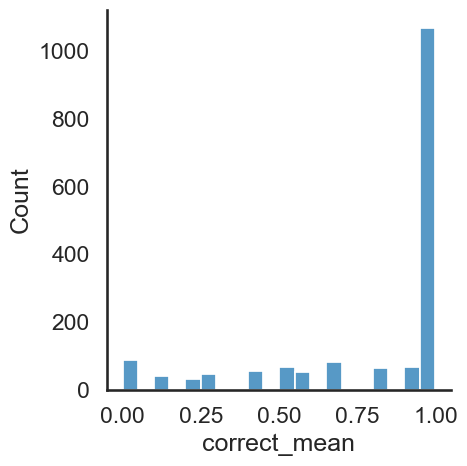

In [29]:
sns.displot(ds.correct_mean)

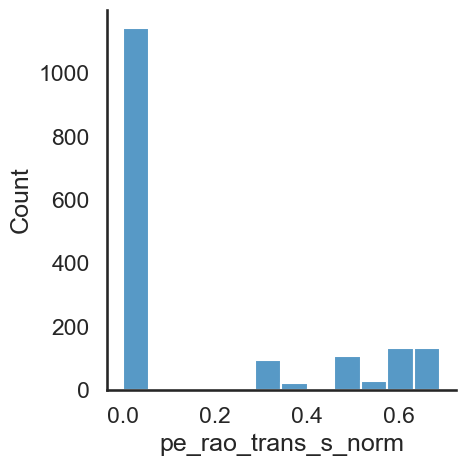

In [30]:
sns.displot(y)

In [31]:
X.isnull().sum().sum() == 0

True

In [32]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [33]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation, entropy

In [34]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

ds_basefeat_gen = ds.reset_index().merge(ae, on=['run', 'pid'], how='left').copy().set_index('index')
ds_basefeat_gen = ds_basefeat_gen.merge(duplicate_counts, on=['run', 'pid'], how='left')
ds_basefeat_gen.index = ds.index
resu[('generated', target)] = (y_res, pred, correct_mean_thr, ds_basefeat_gen)                    

CPU times: user 6.48 s, sys: 1.35 s, total: 7.83 s
Wall time: 1.18 s


In [35]:
all(ds_basefeat_gen.groupby('pid')['count'].sum()==10)

True

In [36]:
correct_mean_thr.value_counts()

correct_mean
True     1335
False     331
Name: count, dtype: int64

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_41144/1560700470.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_joint.set_xticklabels(g.ax_joint.get_xticklabels(), rotation=45)


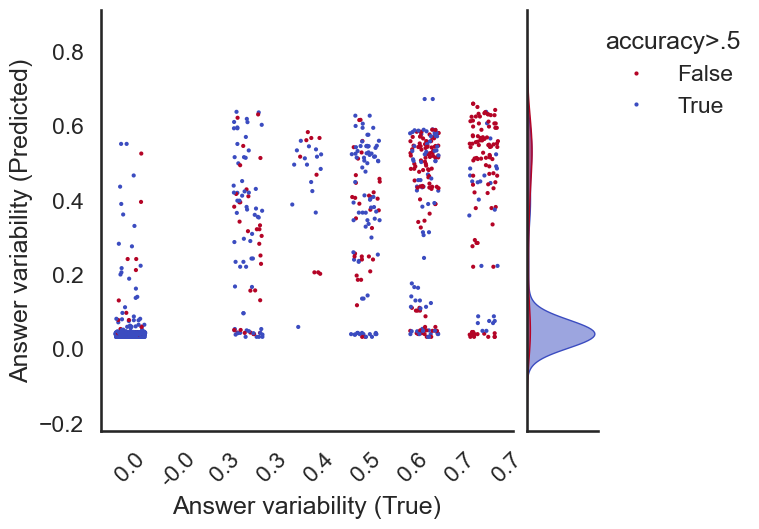

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np

# Define normalization and color palette
norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

# Create JointGrid for custom main plot + marginals
g = sns.JointGrid(x=np.round(y_res.values, 1), y=pred)

# MAIN PLOT (center): stripplot
sns.stripplot(x=np.round(y_res.values,1), y=pred,
              hue=correct_mean_thr,
              palette=palette, size=3, jitter=0.25, ax=g.ax_joint)


sns.kdeplot(y=pred, hue=correct_mean_thr,
            ax=g.ax_marg_y, fill=True,
            palette=palette, linewidth=1, alpha=0.5, common_norm=True)
g.ax_marg_y.legend_.remove()

# Adjust the legend (move to top-right outside plot)
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.175, 1), frameon=False, title='accuracy>.5')

# Despine, style, labels
sns.despine()
g.set_axis_labels("Answer variability (True)", "Answer variability (Predicted)")
# g.ax_joint.set_title(f'Answer variability regression ({target})')

# Fix x-axis ticks
from matplotlib.ticker import MaxNLocator
g.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=10))
g.ax_joint.set_xticklabels(g.ax_joint.get_xticklabels(), rotation=45)

g.ax_marg_x.remove()


plt.show()

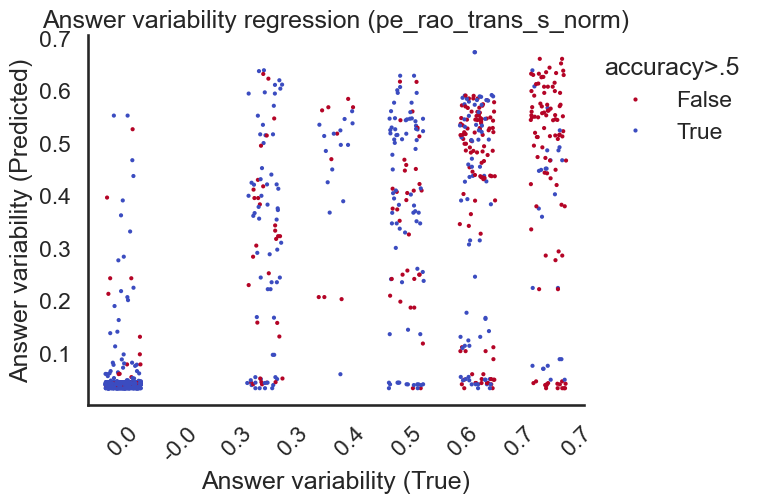

In [38]:
import matplotlib.colors as mcolors

norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1),
                   jitter=0.25, 
                   hue=correct_mean_thr, 
                   size=3, 
                   palette = palette)


sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

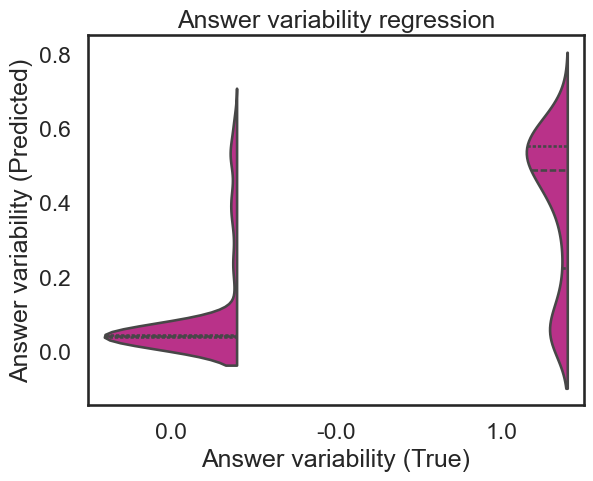

In [39]:
palette = Bold_10.mpl_colors

ax = sns.violinplot(y=pred, x=np.round(y_res.values,0), 
                    split=True, inner="quart", width=0.8, color=palette[8]) # , log_scale=(True,False))

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

plt.show()

In [40]:
met = assessme(y_res.values, pred)
met

{'mae': 0.10292938715430584,
 'mse': 0.028896382400488044,
 'rmse': 0.16998935966844525,
 'r2': 0.5633721805578434,
 'adj_r2': 0.5631097840317363,
 'pearson_corr': 0.7513857186798365,
 'spearman_corr': 0.6453385934112738,
 'kendall_corr': 0.5128975027269493}

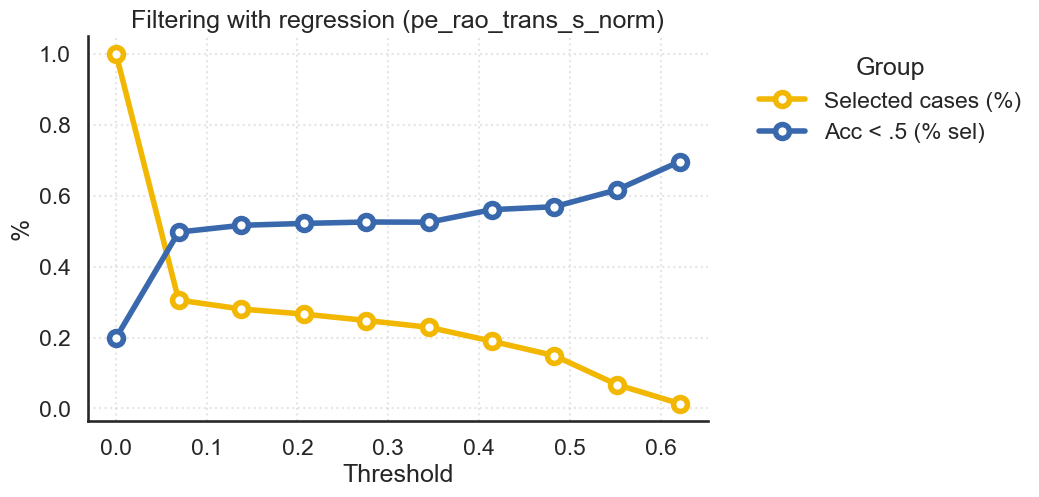

In [41]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

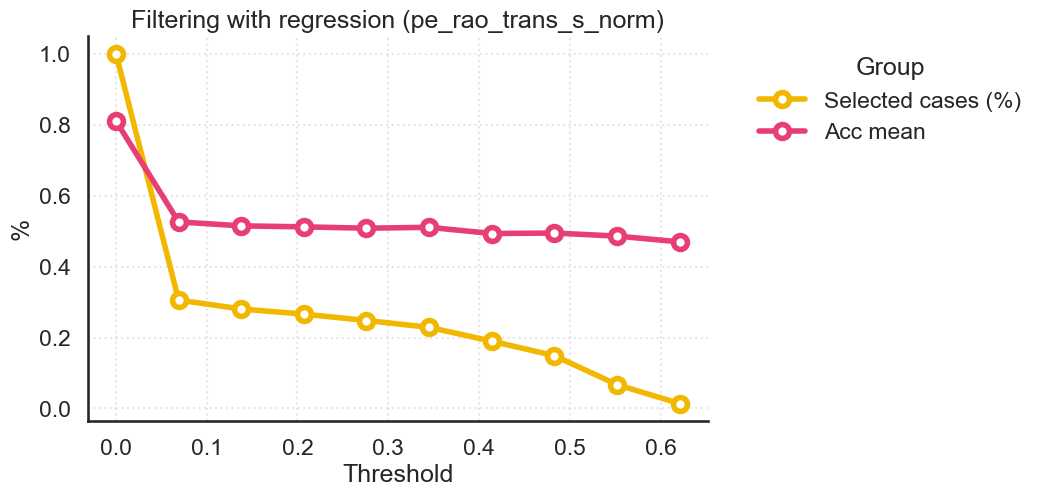

In [42]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [correct_mean[pred>=thr].mean() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc mean", marker="o", color=palette[4], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[4])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

### answers entropy

In [43]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
print(ds.shape, ds.pid.nunique())
duplicate_counts = get_count_map(ds)
ds = ds.drop_duplicates(ds.columns[1:-3])
print(ds.shape, ds.pid.nunique())

y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

(13470, 24) 1347
(1666, 24) 1347


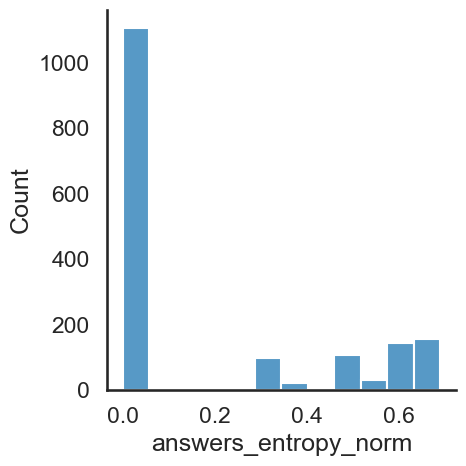

In [44]:
sns.displot(y)

In [45]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

ds_basefeat_gen_ =  ds.reset_index().merge(ae, on=['run', 'pid'], how='left').copy().set_index('index')
ds_basefeat_gen_ = ds_basefeat_gen_.merge(duplicate_counts, on=['run', 'pid'], how='left')
ds_basefeat_gen_.index = ds.index
duplicate_counts_basefeat_gen = duplicate_counts.copy() # store for later use

resu[('generated', target)] = (y_res, pred, correct_mean_thr, ds_basefeat_gen_)

CPU times: user 5.91 s, sys: 2.08 s, total: 7.99 s
Wall time: 1.16 s


In [46]:
all(ds_basefeat_gen_.groupby('pid')['count'].sum()==10)

True

In [47]:
ds.shape, ds.loc[y_res.index].shape

((1666, 24), (1666, 24))

In [48]:
ds.pid.nunique(), ds.loc[y_res.index].pid.nunique()

(1347, 1347)

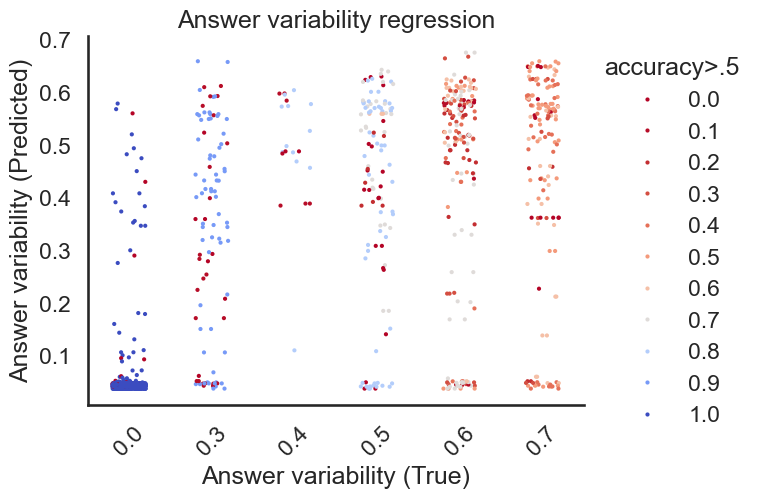

In [49]:
norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), jitter=0.2, hue=correct_mean, size=3, palette=palette) # , log_scale=(True,False))
sns.despine()

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

#from matplotlib.ticker import MaxNLocator
#ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [50]:
met = assessme(y_res.values, pred)
met

{'mae': 0.09570160480017134,
 'mse': 0.025086253211184958,
 'rmse': 0.15838640475490615,
 'r2': 0.649597678884497,
 'adj_r2': 0.6493871005665189,
 'pearson_corr': 0.8064986209832907,
 'spearman_corr': 0.6874391266203117,
 'kendall_corr': 0.5466481701093271}

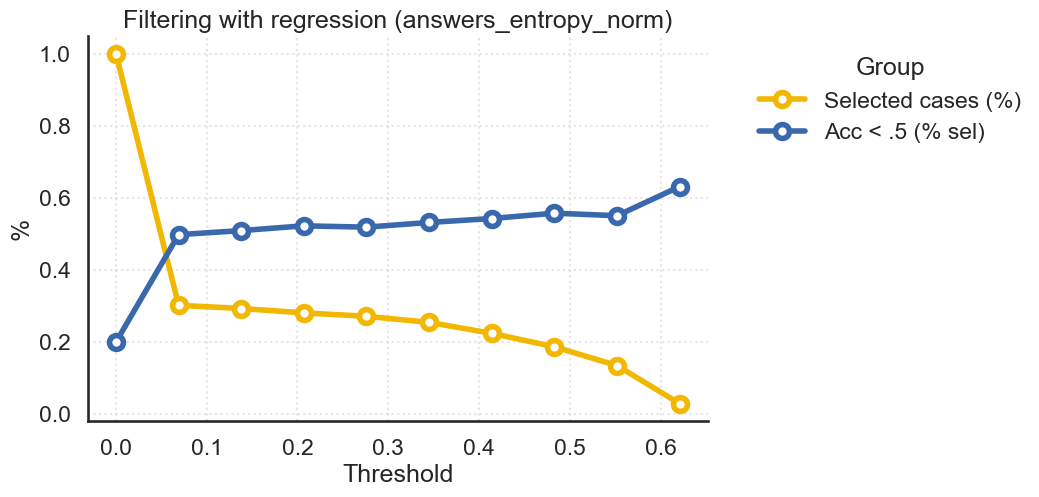

In [51]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred > thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>thr]).sum() / (pred>thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

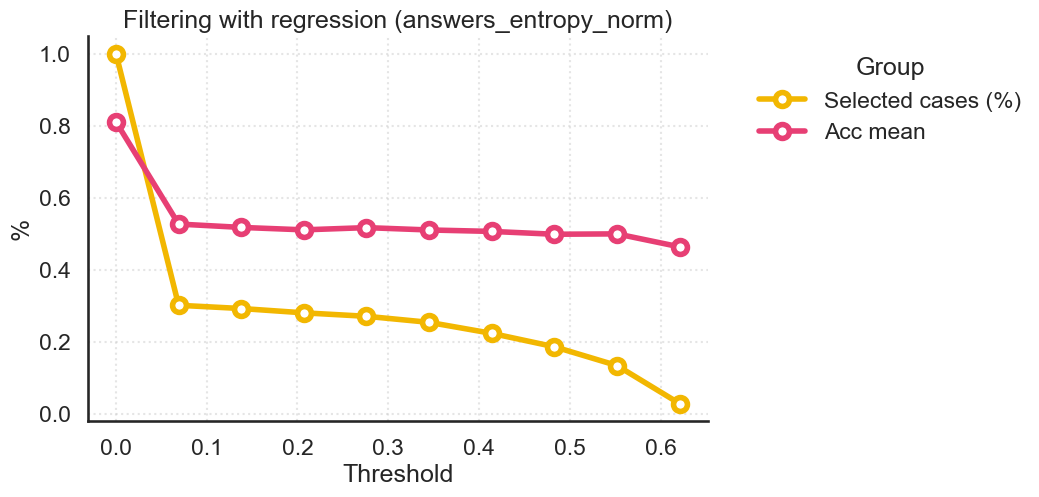

In [52]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [correct_mean[pred>=thr].mean() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc mean", marker="o", color=palette[4], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[4])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

#### mixed results (majority)

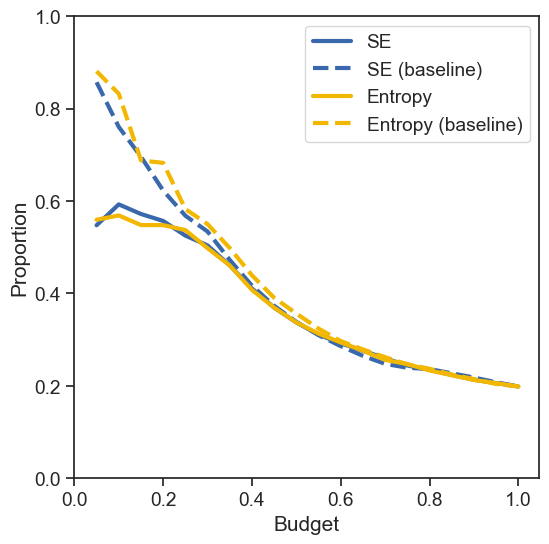

In [53]:
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.25)
plt.figure(figsize=(6, 6))

palette = Bold_10.mpl_colors
nbins=20

###
target = 'pe_rao_trans_s_norm'
y_res, pred, correct_mean_thr, _ = resu[('generated', target)]

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(~correct_mean_thr[b:]).sum() / (len(pred)-b) for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="SE", color=palette[2], linewidth=3, linestyle='-')

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(~correct_mean_thr[b:]).sum() / (len(pred)-b) for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="SE (baseline)", color=palette[2], linewidth=3, linestyle='--')

###
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, _ = resu[('generated', target)]
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(~correct_mean_thr[b:]).sum() / (len(pred)-b) for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="Entropy", color=palette[3], linewidth=3, linestyle='-')

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(~correct_mean_thr[b:]).sum() / (len(pred)-b) for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="Entropy (baseline)", color=palette[3], linewidth=3, linestyle='--')

plt.ylim(0,1)
plt.xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.])

plt.xlabel("Budget")
plt.ylabel("Proportion")


plt.savefig("budget_and_baseline_sum_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

#### mixed results (accuracy)

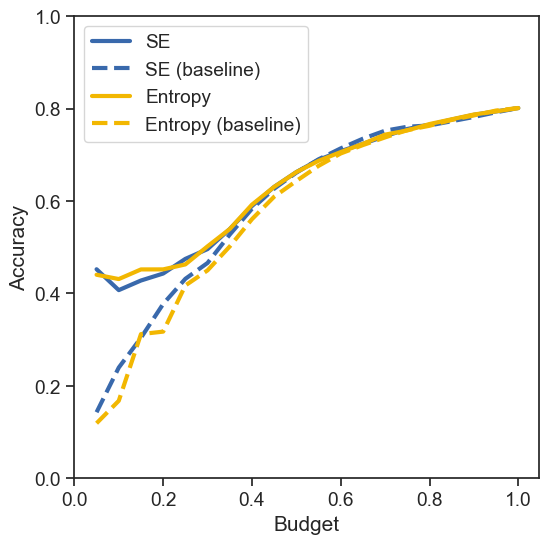

In [54]:
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.25)
plt.figure(figsize=(6, 6))

palette = Bold_10.mpl_colors
nbins=20

###
target = 'pe_rao_trans_s_norm'
y_res, pred, correct_mean_thr, _ = resu[('generated', target)]

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="SE", color=palette[2], linewidth=3, linestyle='-')

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="SE (baseline)", color=palette[2], linewidth=3, linestyle='--')

###
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, _ = resu[('generated', target)]
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="Entropy", color=palette[3], linewidth=3, linestyle='-')

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="Entropy (baseline)", color=palette[3], linewidth=3, linestyle='--')

plt.ylim(0,1)
plt.xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.])

plt.xlabel("Budget")
plt.ylabel("Accuracy")


plt.savefig("budget_and_baseline_mean_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

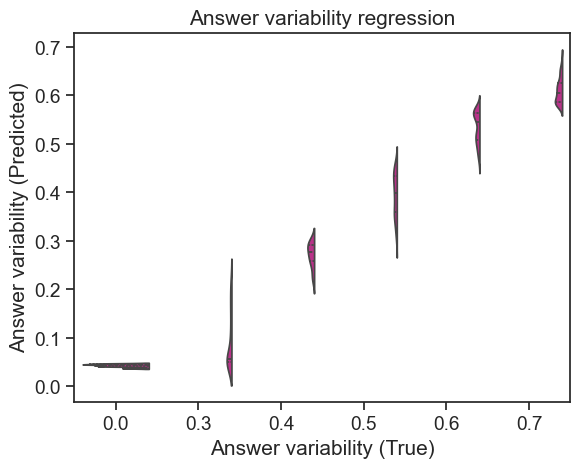

In [55]:
ax = sns.violinplot(y=pred, x=np.round(y_res.values,1), 
                    split=True, inner="quart", width=0.8, color=palette[8]) # , log_scale=(True,False))


plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

plt.show()

In [56]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

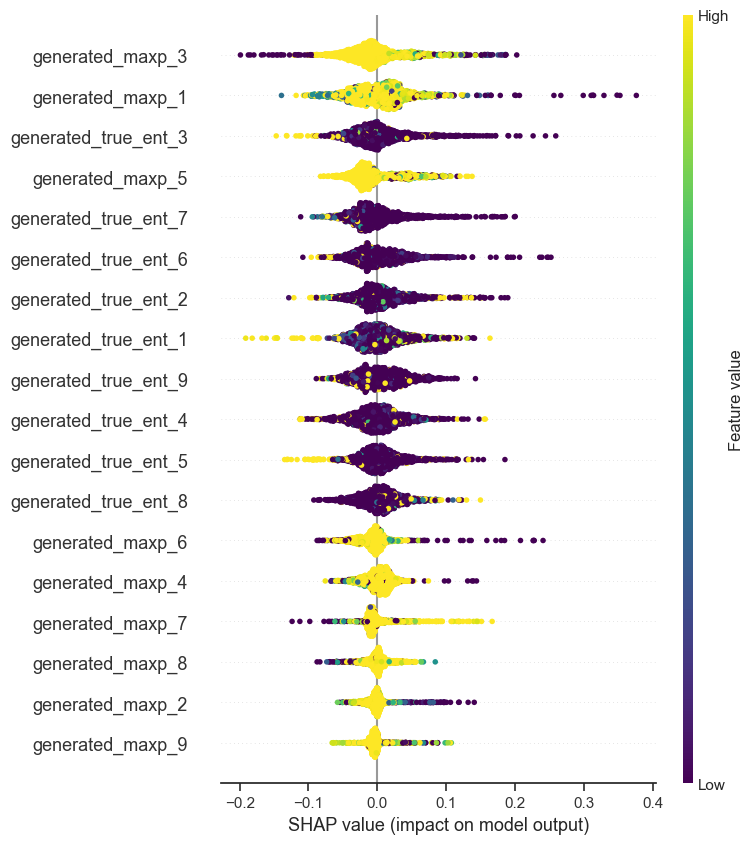

In [57]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [58]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [59]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.422763
generated_true_ent_    0.577237
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

The palette list has more values (10) than needed (9), which may not be intended.


<Axes: xlabel='label', ylabel='value'>

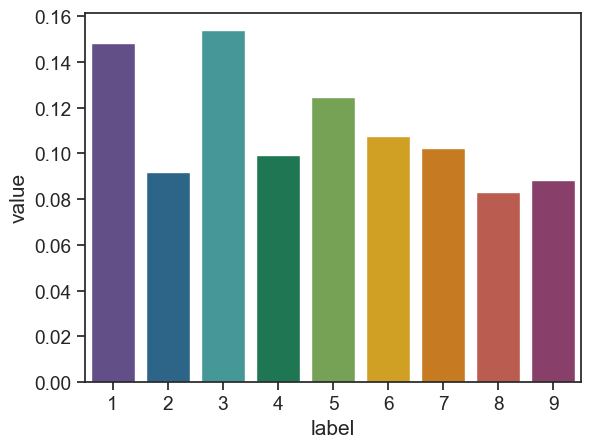

In [60]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(25.30381944444443, 0.5, 'Token index')

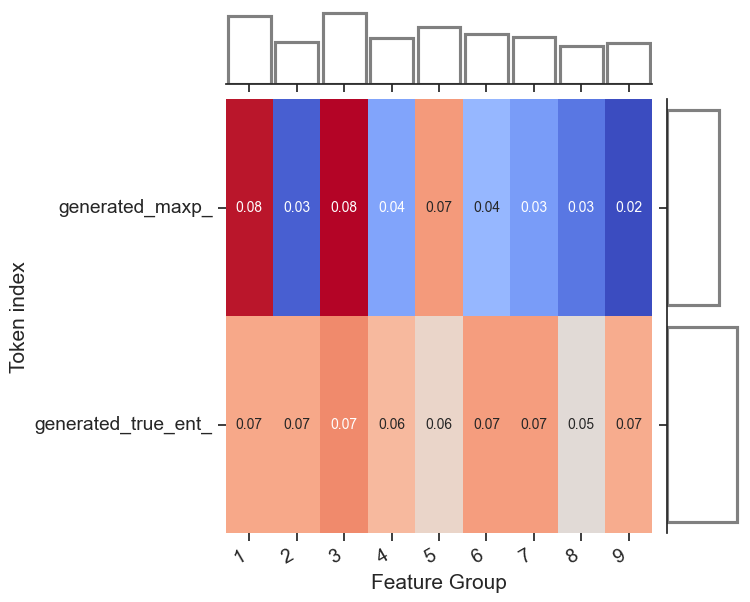

In [61]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### all features, generated

In [62]:
df_logitlens_kl_expanded.columns

Index(['logitlens_kl0', 'logitlens_kl1', 'logitlens_kl2', 'logitlens_kl3',
       'logitlens_kl4', 'logitlens_kl5', 'logitlens_kl6', 'logitlens_kl7',
       'logitlens_kl8', 'logitlens_kl9', 'logitlens_kl10', 'logitlens_kl11',
       'logitlens_kl12', 'logitlens_kl13', 'logitlens_kl14', 'logitlens_kl15',
       'logitlens_kl16', 'logitlens_kl17', 'logitlens_kl18', 'logitlens_kl19',
       'logitlens_kl20', 'logitlens_kl21', 'logitlens_kl22', 'logitlens_kl23',
       'logitlens_kl24', 'logitlens_kl25', 'logitlens_kl26', 'logitlens_kl27',
       'logitlens_kl28', 'logitlens_kl29', 'logitlens_kl30'],
      dtype='object')

In [63]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'

ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
print(ds.shape, ds.pid.nunique())
duplicate_counts = get_count_map(ds)
ds = ds.drop_duplicates(ds.columns[1:-3])
print(ds.shape, ds.pid.nunique())

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
correct_mean_thr = ds.correct_mean > .5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

(13470, 303) 1347
(1672, 303) 1347


In [64]:
X_res.shape

(1672, 297)

In [65]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

ds_generated_kl = ds.reset_index().merge(ae, on=['run', 'pid'], how='left').copy().set_index('index')
ds_generated_kl = ds_generated_kl.merge(duplicate_counts, on=['run', 'pid'], how='left')
ds_generated_kl.index = ds.index
duplicate_counts_generated_kl = duplicate_counts.copy() # store for later use
resu[('generated_kl', target)] = (y_res, pred, correct_mean_thr, ds_generated_kl)

CPU times: user 46.4 s, sys: 4.48 s, total: 50.9 s
Wall time: 8.82 s


In [66]:
all(ds_generated_kl.groupby('pid')['count'].sum()==10)

True

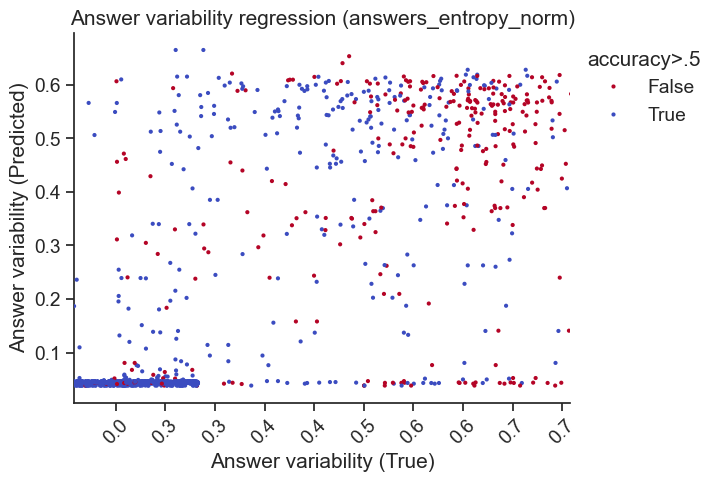

In [67]:
norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean, 
                   size=3, palette=palette) # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [68]:
met = assessme(y_res.values, pred)
met

{'mae': 0.09654854699835609,
 'mse': 0.024157949791554157,
 'rmse': 0.15542827860963448,
 'r2': 0.6632314822684633,
 'adj_r2': 0.6630298244734145,
 'pearson_corr': 0.8153668388062012,
 'spearman_corr': 0.6823217572298133,
 'kendall_corr': 0.5338989653198366}

In [69]:
%%time

import xgboost
import shap

# model = xgboost.XGBRegressor(n_estimators=100, booster='gblinear').fit(X_res, y_res)
model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 9.88 s, sys: 2.05 s, total: 11.9 s
Wall time: 4.71 s


In [70]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

grp
generated_logitlens_kl_    0.400367
generated_maxp_            0.280553
generated_true_ent_        0.319080
Name: value, dtype: float64

Text(25.30381944444443, 0.5, 'Token index')

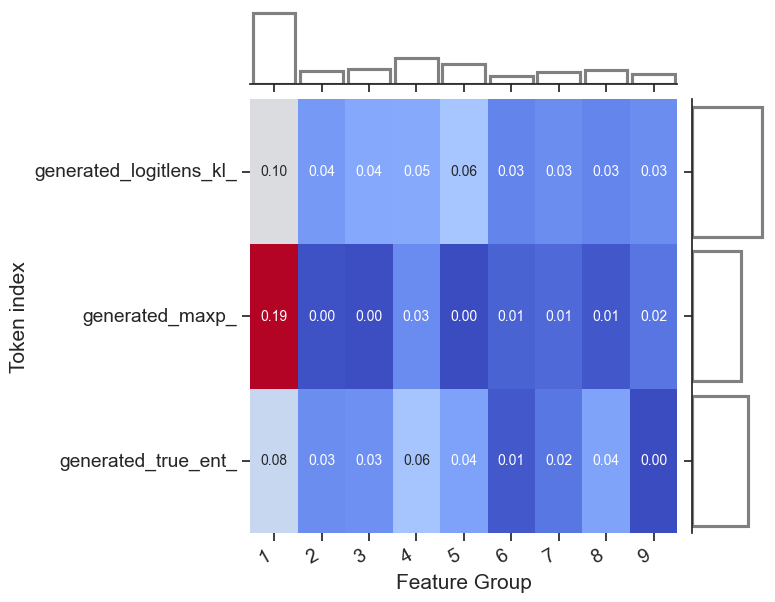

In [71]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### only kl (not saved)

In [72]:
# beginning of generation
N = 10

# selected_features = ['true_ent', 'maxp'] # + list(df_logitlens_kl_expanded.columns) + list(df_logitlens_iou_expanded.columns)
selected_features = list(df_logitlens_kl_expanded.columns)

#selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
print(ds.shape, ds.pid.nunique())
duplicate_counts = get_count_map(ds)
ds = ds.drop_duplicates(ds.columns[1:-3])
print(ds.shape, ds.pid.nunique())

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
correct_mean_thr = ds.correct_mean > .5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

(13470, 285) 1347
(1672, 285) 1347


In [73]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 46 s, sys: 4.73 s, total: 50.7 s
Wall time: 8.7 s


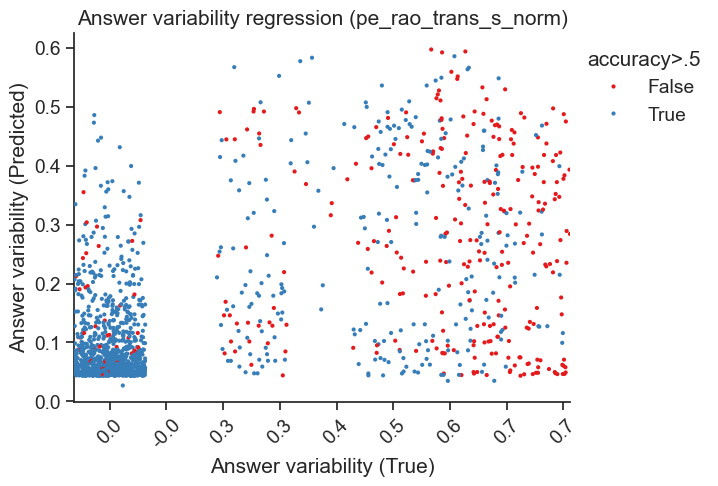

In [74]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=0.5, 
                   hue=correct_mean, 
                   size=3, 
                   palette='Set1') # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [75]:
met = assessme(y_res.values, pred)
met

{'mae': 0.15595771963476388,
 'mse': 0.04545067248915316,
 'rmse': 0.2131916332531677,
 'r2': 0.31491603218058073,
 'adj_r2': 0.3145058022597308,
 'pearson_corr': 0.5655418707765584,
 'spearman_corr': 0.5173051755092535,
 'kendall_corr': 0.3947624442237242}

invalid value encountered in scalar divide


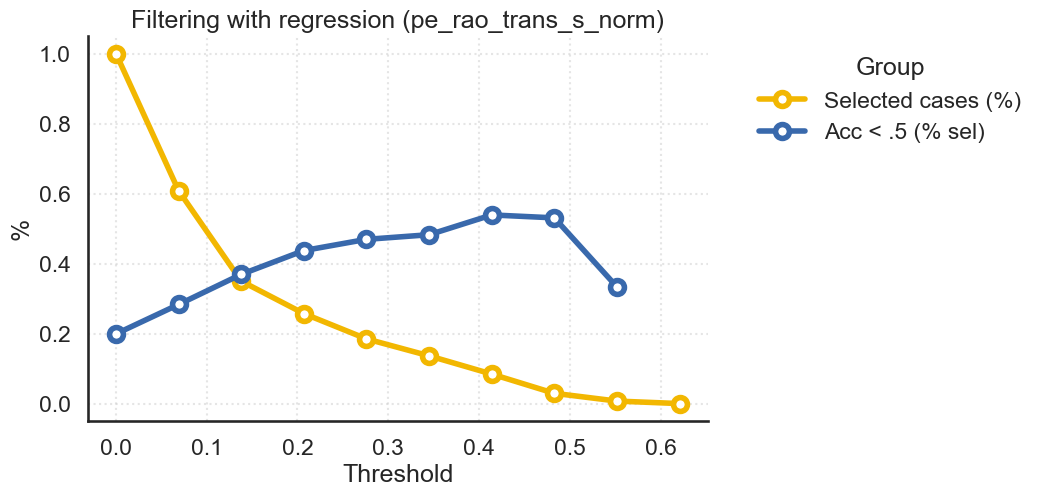

In [76]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

In [77]:
%%time
import xgboost
import shap

# model = xgboost.XGBRegressor(n_estimators=100, booster='gbtree', max_depth=2).fit(X_res, y_res)
model = xgboost.XGBRegressor(n_estimators=100, booster='gblinear').fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 1.28 s, sys: 205 ms, total: 1.48 s
Wall time: 207 ms


In [78]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

# vals.groupby('grp').value.sum()

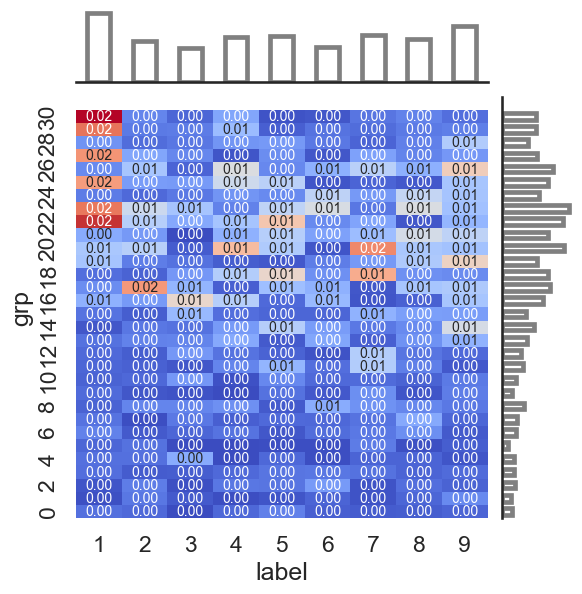

In [79]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

In [80]:
# besties (cardinality given by sqrt)
besties = list(vals[vals.label_orig.str.contains('logitlens')].sort_values('value', ascending=False)[:18].label_orig)

In [81]:
%%time

# another booster bits the dust

import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100, booster='gblinear').fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 962 ms, sys: 288 ms, total: 1.25 s
Wall time: 208 ms


In [82]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

# vals.groupby('grp').value.sum()

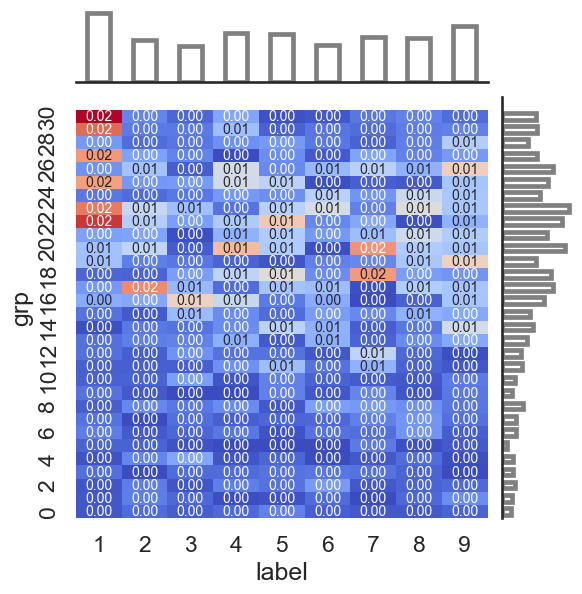

In [83]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

### only best kl features with original ones

In [84]:
# beginning of generation
N = 10

selected_features = ['maxp', 'true_ent'] + list(df_logitlens_kl_expanded.columns)


# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
duplicate_counts = get_count_map(ds)
ds = ds.drop_duplicates(ds.columns[1:-3])

ds = ds[[c for c in ds.columns if c in besties or 'logitlens' not in c]]

y = ds[target].abs().round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [85]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 4.82 s, sys: 583 ms, total: 5.41 s
Wall time: 785 ms


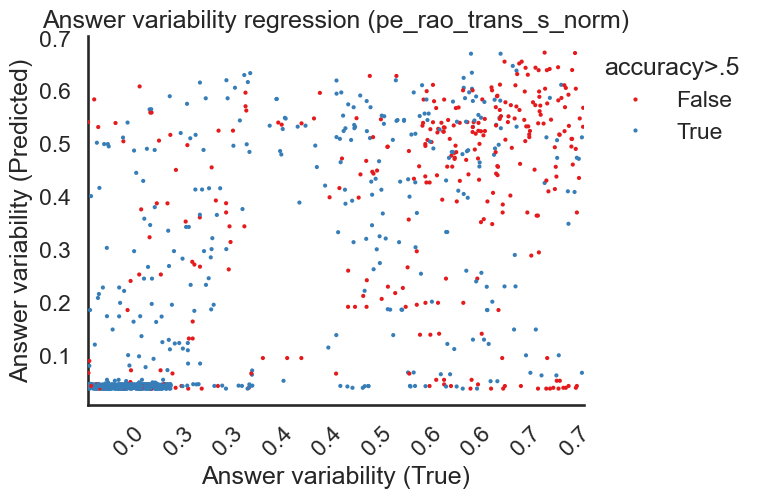

In [86]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=0.5, 
                   hue=correct_mean, 
                   size=3, 
                   palette='Set1') # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [87]:
met = assessme(y_res.values, pred)
met

{'mae': 0.10031494832994266,
 'mse': 0.026783656465148655,
 'rmse': 0.16365713081057193,
 'r2': 0.5962864213233523,
 'adj_r2': 0.5960446766654621,
 'pearson_corr': 0.7724655900013908,
 'spearman_corr': 0.6658849163671948,
 'kendall_corr': 0.5304352549600607}

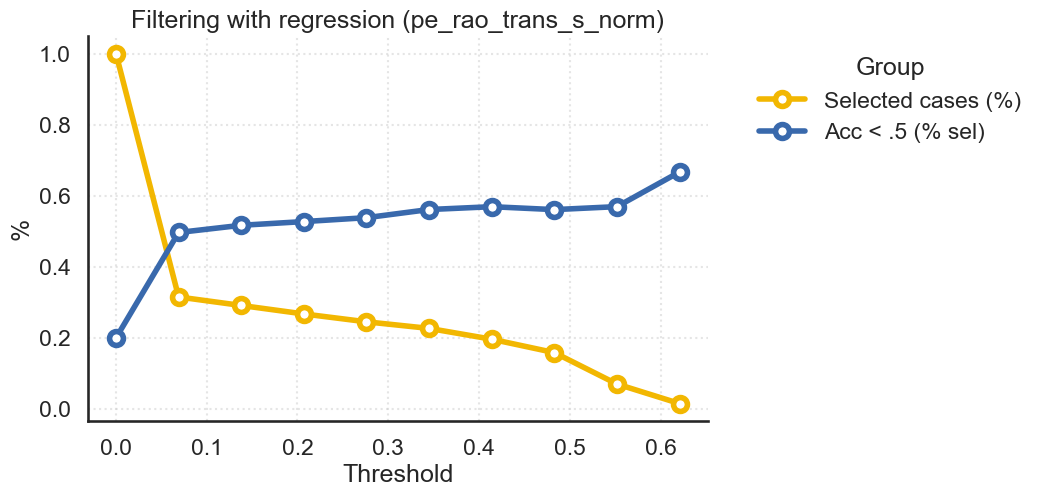

In [88]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

In [89]:
%%time

import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 5.32 s, sys: 575 ms, total: 5.89 s
Wall time: 3.42 s


Text(33.22569444444443, 0.5, 'Token index')

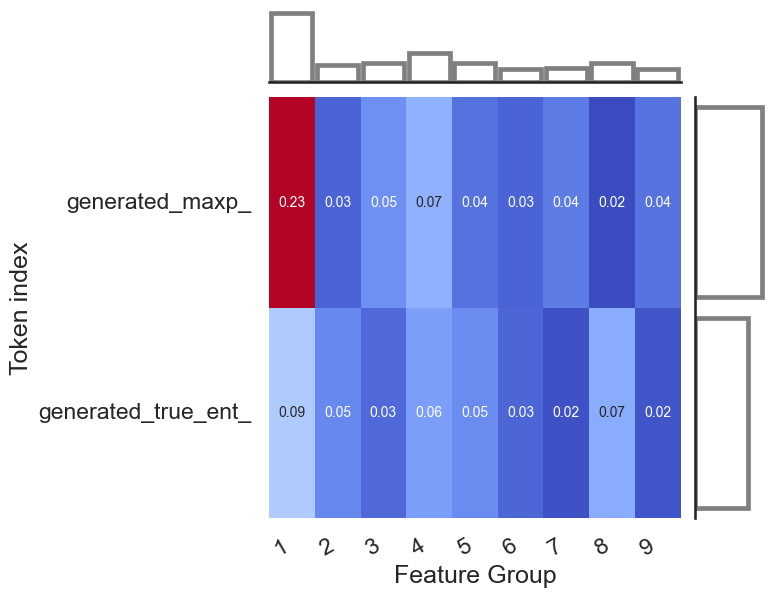

In [90]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### postilla (no kl)

In [91]:
# beginning of generation
selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
print(ds.shape, ds.pid.nunique())
duplicate_counts = get_count_map(ds)
ds = ds.drop_duplicates(ds.columns[1:-3])
print(ds.shape, ds.pid.nunique(), duplicate_counts.shape)

y = ds[target].round(2)
correct_mean = ds.correct_mean
correct_mean_thr = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

(13470, 138) 1347
(2094, 138) 1347 (13470, 3)


In [92]:
ds[['pid', 'correct']].drop_duplicates().shape

(1569, 2)

In [93]:
duplicate_counts

,run,pid,count
0,0,0,5
1,1,0,2
2,2,0,5
3,3,0,5
4,4,0,5
...,...,...,...
13465,5,1800,9
13466,6,1800,9
13467,7,1800,9
13468,8,1800,9


In [94]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

ds_postilla =  ds.reset_index().merge(ae, on=['run', 'pid'], how='left').copy().set_index('index')
ds_postilla = ds_postilla.merge(duplicate_counts, on=['run', 'pid'], how='left')
ds_postilla.index = ds.index
resu[('postilla', target)] = (y_res, pred, correct_mean_thr, ds_postilla)

CPU times: user 22.4 s, sys: 4.15 s, total: 26.5 s
Wall time: 5.06 s


In [95]:
all(ds_postilla.groupby('pid')['count'].sum()==10)

True

### postilla (no kl) but on same cases that generated

In [96]:
# beginning of generation
selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# reconcile cases with "generated" experiment (instead of dropping duplicates)
print(ds.shape, ds.pid.nunique())
ds = ds_basefeat_gen[['run', 'pid', 'correct']].merge(ds, on=['run', 'pid', 'correct'], how='left')
print(ds.shape, ds.pid.nunique())

y = ds[target].round(2)
correct_mean = ds.correct_mean
correct_mean_thr = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

(13470, 138) 1347
(1666, 138) 1347


In [97]:
%%time

# reconcile

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

ds_postilla_reconciled =  ds.reset_index().merge(ae, on=['run', 'pid'], how='left').copy().set_index('index')
ds_postilla_reconciled_ = ds_postilla_reconciled.merge(duplicate_counts_basefeat_gen, 
                                                       on=['run', 'pid'], 
                                                       how='left')
ds_postilla_reconciled_.index = ds.index
resu[('postilla_reconciled', target)] = (y_res, pred, correct_mean_thr, ds_postilla_reconciled_)

CPU times: user 22.1 s, sys: 3.55 s, total: 25.7 s
Wall time: 4.56 s


In [98]:
all(ds_postilla_reconciled_.groupby('pid')['count'].sum()==10)

True

In [99]:
all(ds_postilla_reconciled_[ds_postilla_reconciled_.columns[:-1]] == ds_postilla_reconciled)

True

### postilla + kl

In [100]:
# beginning of generation
selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
duplicate_counts = get_count_map(ds)
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean
correct_mean_thr = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [101]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

ds_postilla_kl =  ds.reset_index().merge(ae, on=['run', 'pid'], how='left').copy().set_index('index')
ds_postilla_kl = ds_postilla_kl.merge(duplicate_counts, on=['run', 'pid'], how='left')
ds_postilla_kl.index = ds.index
resu[('postilla_kl', target)] = (y_res, pred, correct_mean_thr, ds_postilla_kl)

CPU times: user 3min 46s, sys: 16.3 s, total: 4min 2s
Wall time: 45.8 s


In [102]:
all(ds_postilla_kl.groupby('pid')['count'].sum()==10)

True

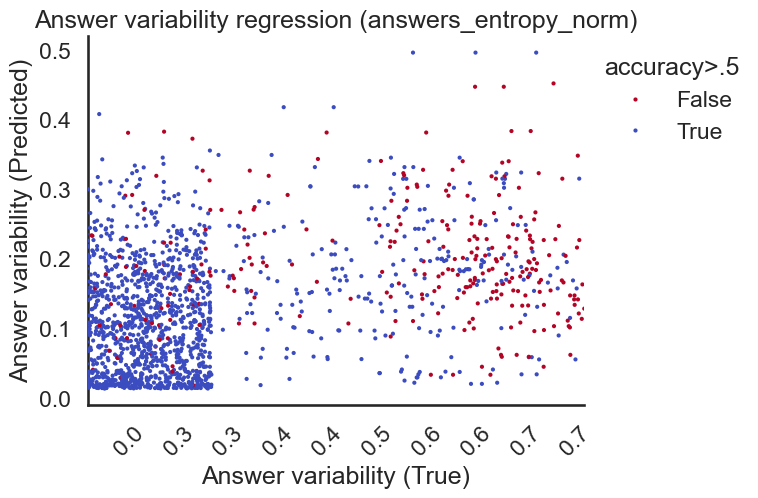

In [103]:
import matplotlib.colors as mcolors

norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean_thr, 
                   size=3, 
                   palette = palette)
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [104]:
met = assessme(y_res.values, pred)
met

{'mae': 0.175043291587564,
 'mse': 0.05351864964192171,
 'rmse': 0.23134098132825864,
 'r2': 0.1502017569558849,
 'adj_r2': 0.1497955436465903,
 'pearson_corr': 0.39890696871106285,
 'spearman_corr': 0.39928467723552835,
 'kendall_corr': 0.30660382406486497}

invalid value encountered in scalar divide


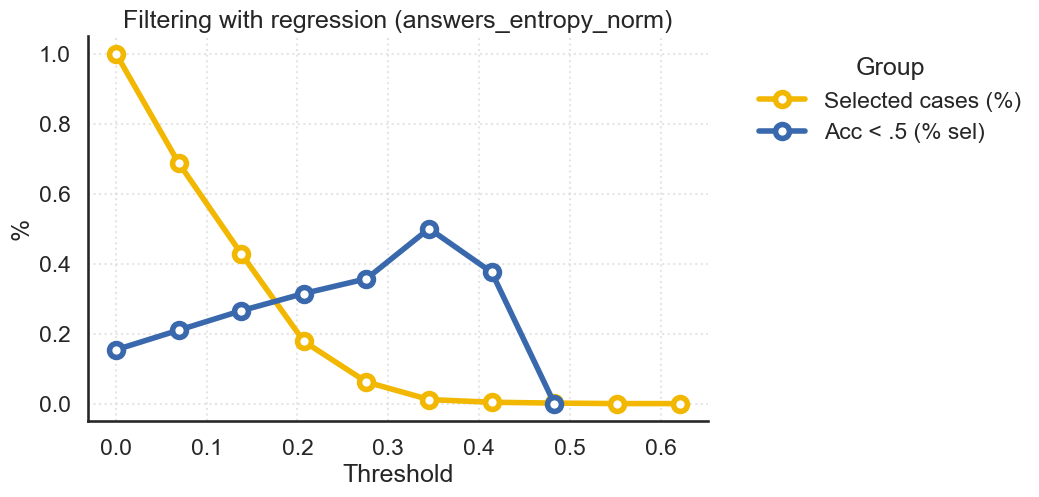

In [105]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred > thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>thr]).sum() / (pred>thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

### postilla + kl, but on same cases that generated + kl

In [106]:
# beginning of generation
selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# reconcile cases with "generated + kl" experiment (instead of dropping duplicates)
print(ds.shape, ds.pid.nunique())
ds = ds_generated_kl[['run', 'pid', 'correct']].merge(ds, on=['run', 'pid', 'correct'], how='left')
print(ds.shape, ds.pid.nunique())

y = ds[target].round(2)
correct_mean = ds.correct_mean
correct_mean_thr = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

(13470, 2184) 1347
(1672, 2184) 1347


In [107]:
X_res.shape, y_res.shape, pids_res.shape

((1672, 2178), (1672,), (1672,))

In [108]:
# reconcile

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

ds_postilla_kl_reconciled =  ds.reset_index().merge(ae, on=['run', 'pid'], how='left').copy().set_index('index')
ds_postilla_kl_reconciled_ = ds_postilla_kl_reconciled.merge(duplicate_counts_generated_kl, 
                                on=['run', 'pid'], 
                                how='left')
ds_postilla_kl_reconciled_.index = ds.index
resu[('postilla_kl_reconciled', target)] = (y_res, pred, correct_mean_thr, ds_postilla_kl_reconciled_)

In [109]:
all(ds_postilla_kl_reconciled_.groupby('pid')['count'].sum()==10)

True

### put graphs together

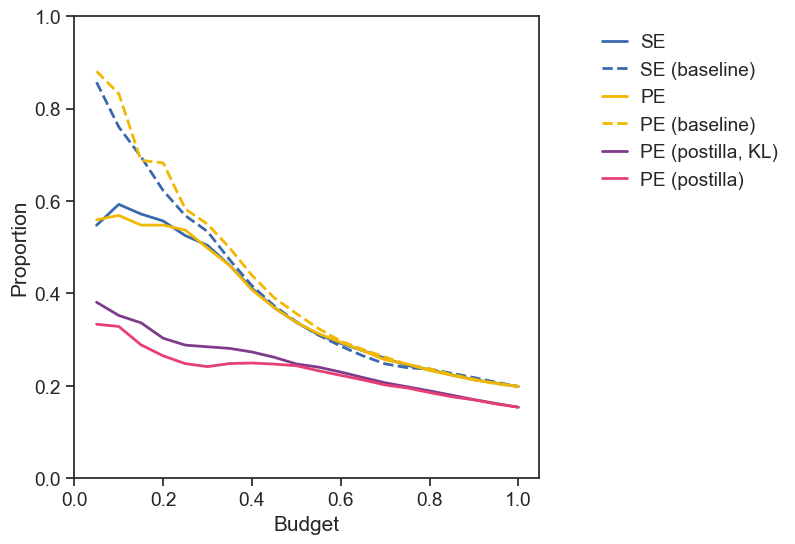

In [110]:
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.25)
plt.figure(figsize=(6, 6))

palette = Bold_10.mpl_colors
nbins=20

###
target = 'pe_rao_trans_s_norm'
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(~correct_mean_thr[b:]).sum() / (len(pred)-b) for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="SE", color=palette[2], linewidth=2, linestyle='-')

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(~correct_mean_thr[b:]).sum() / (len(pred)-b) for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="SE (baseline)", color=palette[2], linewidth=2, linestyle='--')

###
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(~correct_mean_thr[b:]).sum() / (len(pred)-b) for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE", color=palette[3], linewidth=2, linestyle='-')

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(~correct_mean_thr[b:]).sum() / (len(pred)-b) for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (baseline)", color=palette[3], linewidth=2, linestyle='--')


###
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('postilla_kl', target)]
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(~correct_mean_thr[b:]).sum() / (len(pred)-b) for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (postilla, KL)", color=palette[0], linewidth=2, linestyle='-')

###
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('postilla', target)]
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

cases_rel = [(len(pred)-b) / len(pred) for b in bs]
unsure_count = [(~correct_mean_thr[b:]).sum() / (len(pred)-b) for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (postilla)", color=palette[4], linewidth=2, linestyle='-')

##########

plt.ylim(0,1)
plt.xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.])

plt.xlabel("Budget")
plt.ylabel("Proportion")

handles1, labels1 = plt.gca().get_legend_handles_labels()

plt.legend(
    handles=handles1,
    title="",
    loc="upper right",
    bbox_to_anchor=(1.55, 1),
    frameon=False,
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.7,
     handlelength=1.3
)

plt.savefig("budget_and_baseline_sum_postilla_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

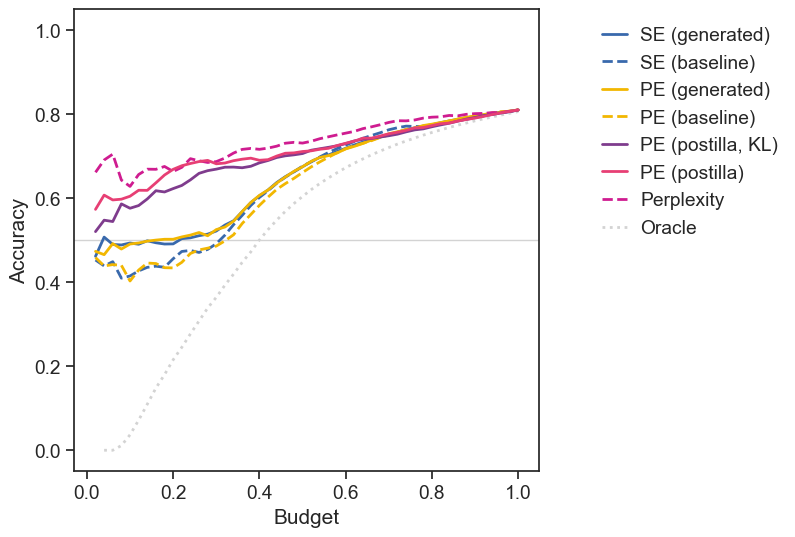

In [111]:
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.25)
plt.figure(figsize=(6, 6))

nbins=50
palette = Bold_10.mpl_colors

plt.axhline(y=0.5, color='lightgrey', linewidth=1, zorder=0, linestyle='-')

### SE, generated, no kl
target = 'pe_rao_trans_s_norm'
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="SE (generated)", color=palette[2], linewidth=2, linestyle='-')

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="SE (baseline)", color=palette[2], linewidth=2, linestyle='--')

# baseline (true accuracy)
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

accu = myds.correct_mean.sort_values()
correct_mean_thr = correct_mean_thr.loc[accu.index]

unsure_count = list(reversed([(correct_mean_thr[:b]).mean() for b in bs]))

ax = sns.lineplot(x=bs_, y=unsure_count, label="Oracle", color='lightgrey', linewidth=2, linestyle=':')

### entropy, generated, no kl
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (generated)", color=palette[3], linewidth=2, linestyle='-')

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (baseline)", color=palette[3], linewidth=2, linestyle='--')


# perplexity as a baseline
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

perp = myds.perplexity_l.sort_values()
y_res = y_res.loc[perp.index]
correct_mean_thr = correct_mean_thr.loc[perp.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="Perplexity", color=palette[8], linewidth=2, linestyle='--')


### entropy, postilla, kl
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('postilla_kl_reconciled', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (postilla, KL)", color=palette[0], 
                  linewidth=2, linestyle='-')

### entropy, postilla, kl
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('postilla_reconciled', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (postilla)", color=palette[4], 
                  linewidth=2, linestyle='-')



########
plt.ylim(-0.05,1.05)
plt.xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.])

plt.xlabel("Budget")
plt.ylabel("Accuracy")

handles1, labels1 = plt.gca().get_legend_handles_labels()

handles1 = [handles1[i] for i in [0,1,3,4,6,7,5,2]]
labels1 = [labels1[i] for i in [0,1,3,4,6,7,5,2]]

plt.legend(
    handles=handles1,
    title="",
    loc="upper right",
    bbox_to_anchor=(1.55, 1),
    frameon=False,
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.7,
     handlelength=1.3
)

plt.savefig("budget_and_baseline_mean_postilla_global_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

In [112]:
# dump results

with open('resu' + model_name_short + '.pickle', 'wb') as handle:
    pickle.dump(resu, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [113]:
for k,v in resu.items():
    d = v[3]
    print(all(d.groupby('pid')['count'].sum()==10))

True
True
True
True
True
True
True


### increasing number of cases

In [115]:
ds.pid.nunique()

1347

In [116]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
duplicate_counts = get_count_map(ds)
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

#X_res, y_res = X, y # rus.fit_resample(X, y)
#pids_res = pids # [y_res.index]

# X_res.columns = ['generated_'+col for col in X.columns]

In [117]:
group_kfold = GroupKFold(n_splits=10)

foldlist = []

for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, pids)):
    foldlist.append(test_index)

In [118]:
# %%time

prog = []

# cycle all
for i, idxs in enumerate(foldlist):
    print(i)
    
    test_idx = idxs
    
    # cycle all, skipping i
    train_idx = set()
    c = 0
    
    # tutti gli id fuorché la fold corrente
    foldlist_ = [idxs_ for (j, idxs_) in enumerate(foldlist) if i != j]
    fold_train_idx = np.concatenate(foldlist_)
    
    # cycle all available pids
    fold_pids = pids.iloc[fold_train_idx]
    
    for pid in tqdm(fold_pids.unique()):
        
        # enlarge dataset one pid at a time
        train_idx = set(train_idx) | set(fold_train_idx[fold_pids == pid]) 
        train_idx = list(train_idx)

        xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=4)
        xgb_model.fit(X.iloc[train_idx], y.iloc[train_idx])

        pred = xgb_model.predict(X.iloc[test_idx])
        
        # always test on out-of-fold data
        met = assessme(y.iloc[test_idx].values, pred)

        prog.append((i, c, len(train_idx), met['mae'], met['mse'], met['rmse'], met['r2'],
                    met['pearson_corr'], met['spearman_corr'], met['kendall_corr']))
        c += 1
            

0


  0%|                                                  | 0/1212 [00:00<?, ?it/s]An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
 22%|████████▋                               | 264/1212 [00:12<00:46, 20.61it/s]


KeyboardInterrupt: 

In [119]:
prog_ = pd.DataFrame(prog, columns=['i', 'c', 'n', 'mae', 'mse', 'rmse', 'r2', 'pearson_corr', 'spearman_corr', 'kendall_corr'])

In [120]:
prog_

,i,c,n,mae,mse,rmse,r2,pearson_corr,spearman_corr,kendall_corr
0,0,0,2,0.485749,0.306637,0.553748,-3.254145,NaN,NaN,NaN
1,0,1,3,0.177616,0.054629,0.233728,0.242104,0.503542,0.241367,0.209911
2,0,2,4,0.145841,0.059488,0.243902,0.174691,0.523879,0.343666,0.293755
3,0,3,5,0.139882,0.061206,0.247398,0.150861,0.530461,0.437147,0.363971
4,0,4,6,0.139792,0.058302,0.241458,0.191147,0.547971,0.525235,0.417971
...,...,...,...,...,...,...,...,...,...,...
259,0,259,323,0.085141,0.021057,0.145111,0.707862,0.844456,0.867990,0.755160
260,0,260,324,0.086214,0.021375,0.146204,0.703446,0.842106,0.817664,0.691859
261,0,261,325,0.089215,0.022704,0.150678,0.685018,0.830676,0.873043,0.753798
262,0,262,326,0.087152,0.021615,0.147019,0.700127,0.839651,0.810554,0.690438


In [132]:
prog_.shape

(12123, 7)

In [133]:
prog_

,i,c,n,mae,mse,rmse,r2
0,0,0,2,0.485749,0.306637,0.553748,-3.254145
1,0,1,3,0.177616,0.054629,0.233728,0.242104
2,0,2,4,0.145841,0.059488,0.243902,0.174691
3,0,3,5,0.139882,0.061206,0.247398,0.150861
4,0,4,6,0.139792,0.058302,0.241458,0.191147
...,...,...,...,...,...,...,...
12118,9,1207,1495,0.086763,0.017804,0.133431,0.737333
12119,9,1208,1496,0.086486,0.017579,0.132587,0.740646
12120,9,1209,1497,0.086146,0.017345,0.131699,0.744107
12121,9,1210,1498,0.086566,0.017579,0.132584,0.740659


In [322]:
with open('prog_' + model_name_short + '.pickle', 'wb') as handle:
        pickle.dump(prog_, handle, protocol=pickle.HIGHEST_PROTOCOL)

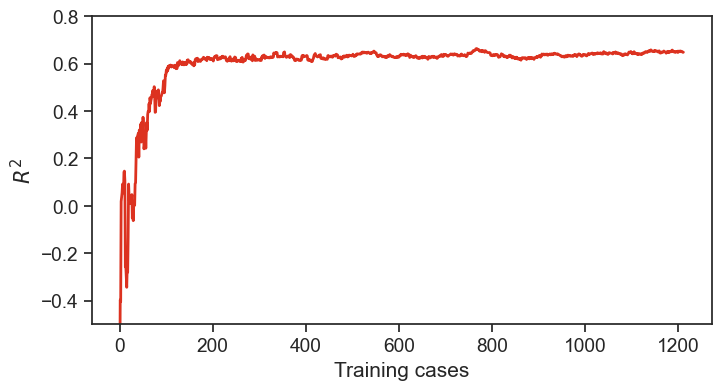

In [196]:
def smooth_data(df, column, window=10):
    return df.groupby("i")[column].transform(lambda x: x.rolling(window, win_type="gaussian").mean(std=2))

prog_["mae_smooth"] = smooth_data(prog_, "mae", window=15)
prog_["r2_smooth"] = smooth_data(prog_, "r2", window=15)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.25)

from palettable.cartocolors.qualitative import Prism_10, Bold_10

plt.figure(figsize=(8, 4))

maxc=prog_.c.max()
prog__ = prog_[prog_.c<maxc]

sns.lineplot(prog__, x="c", y="r2", errorbar=None, color='#DC3220', linewidth = 2)
# plt.title("Entropy regression MAE over number of PIDs in training")
plt.xlabel("Training cases")
plt.ylabel("$R^2$")
plt.ylim(-0.5,0.8)

plt.savefig('progressive_training_' + model_name_short + '.pdf', format="pdf", bbox_inches="tight", dpi=600)

<Axes: xlabel='c', ylabel='mae'>

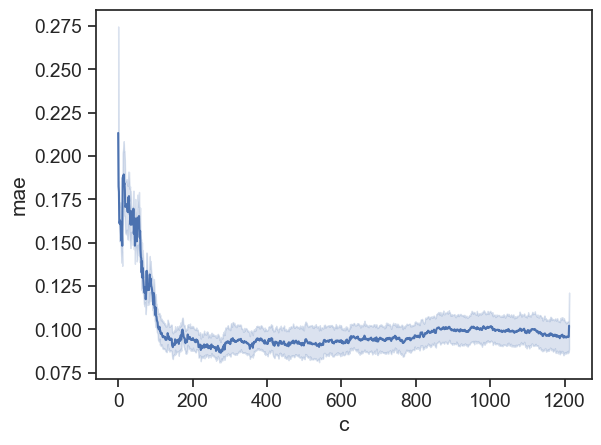

In [127]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

<Axes: xlabel='c', ylabel='mae'>

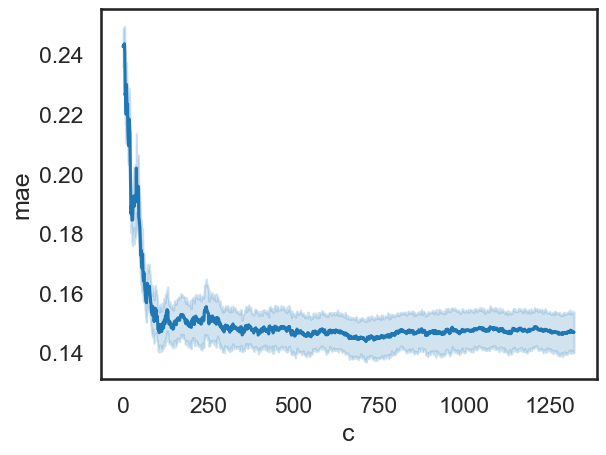

In [85]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

### variable window

In [157]:
target = 'answers_entropy_norm'

#### postilla + generated

In [158]:
ds1 = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds2 = mmg[(mmg.segment=='generated')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
mingen = mmg[(mmg.segment=='generated')].groupby('pid').tokzero.max().min()
postilla_shift = mmg[(mmg.segment=='postilla')].tokzero.max()
ds2.tokzero += postilla_shift + 1
dss = pd.concat([ds1, ds2]).copy()

In [159]:
dss.shape

(1219600, 6)

In [160]:
dss.columns[1:-1]

Index(['pid', 'tokzero', 'shape', 'true_ent'], dtype='object')

In [168]:
%%time

# postilla

outs_combo = []

for K in reversed(range(postilla_shift+mingen, 0, -2)):
    clear_output(wait=True)
    print(K, end='\r')
    ds = dss[(dss.tokzero<=K)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
    ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.merge(truth, on=['run', 'pid'])
    ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-3])
    
    for r in range(4):
        ds = ds.sample(frac=1) # randomism

        y = ds[target].round(2)
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'correct_mean', 'answers_entropy_norm'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        
        xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=4)
        
        pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), groups=pids_res)
    
        outs_combo.append((r, K, pred, y_res))

CPU times: user 19min 49s, sys: 3min 24s, total: 23min 13s
Wall time: 3min 29s


#### postilla + generated + kl

In [171]:
selected_features = list(df_logitlens_kl_expanded.columns) + ['true_ent', 'maxp']

ds1 = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]
ds2 = mmg[(mmg.segment=='generated')][['run', 'pid', 'tokzero'] + selected_features]

mingen = mmg[(mmg.segment=='generated')].groupby('pid').tokzero.max().min()
postilla_shift = mmg[(mmg.segment=='postilla')].tokzero.max()

ds2.tokzero += postilla_shift + 1
dss = pd.concat([ds1, ds2]).copy()

In [174]:
%%time

outs_generated_kl = []

besties_ = [b.replace('generated_', '') for b in besties]
besties_layers = list(set((['_'.join(b.split('_')[:-1]) for b in besties_])))

selected_features = ['true_ent', 'maxp'] + besties_layers

# for K in range(0, postilla_shift+mingen+1, 1):
for K in reversed(range(postilla_shift+mingen, 0, -2)):
    clear_output(wait=True)
    print(K, end='\r')
    ds = dss[(dss.tokzero<=K)][['run', 'pid', 'tokzero'] + selected_features]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()
    ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
    ds = ds.merge(truth, on=['run', 'pid'])
    ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-3])
    
    for r in range(4):
        ds = ds.sample(frac=1)
        y = ds[target].round(2)
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'correct_mean', 'answers_entropy_norm'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)

        xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=4)
        
        pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), groups=pids_res)
    
        outs_generated_kl.append((r, K, pred, y_res))    

CPU times: user 1h 38min 30s, sys: 9min 6s, total: 1h 47min 37s
Wall time: 18min 39s


#### kl only

In [175]:
selected_features = list(df_logitlens_kl_expanded.columns)

ds1 = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]
ds2 = mmg[(mmg.segment=='generated')][['run', 'pid', 'tokzero'] + selected_features]

mingen = mmg[(mmg.segment=='generated')].groupby('pid').tokzero.max().min()
postilla_shift = mmg[(mmg.segment=='postilla')].tokzero.max()

ds2.tokzero += postilla_shift + 1
dss = pd.concat([ds1, ds2]).copy()

In [176]:
%%time

outs_generated_kl_only = []

besties_ = [b.replace('generated_', '') for b in besties]
besties_layers = list(set((['_'.join(b.split('_')[:-1]) for b in besties_])))

selected_features = besties_layers

for K in reversed(range(postilla_shift+mingen, 0, -2)):
    clear_output(wait=True)
    print(K, end='\r')
    ds = dss[(dss.tokzero<=K)][['run', 'pid', 'tokzero'] + selected_features]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()
    ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
    ds = ds.merge(truth, on=['run', 'pid'])
    ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-3])
    
    for r in range(4):
        ds = ds.sample(frac=1)
        y = ds[target].round(2)
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'correct_mean', 'answers_entropy_norm'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        
        xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=4)
        
        pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), groups=pids_res)
    
        outs_generated_kl_only.append((r, K, pred, y_res))    

CPU times: user 1h 28min 2s, sys: 9min 24s, total: 1h 37min 27s
Wall time: 16min 52s


#### graph

In [69]:
if True:
    pw = {'outs_generated_kl': outs_generated_kl,
        'outs_generated_kl_only': outs_generated_kl_only,
        'outs_combo': outs_combo
         }
    with open('progressive_window_data' + model_name_short + '.pickle', 'wb') as handle:
        pickle.dump(pw, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [184]:
# generated with entropy/maxp features

aucs = []
for r, K, pred, y_res in outs_combo:
    met = assessme(y_res.values, pred)
    aucs.append((r, K, met['r2']))
    
aucs_1 = pd.DataFrame(aucs, columns=['r', 'k', 'r2'])
aucs_1['src'] = 'Entropy / MaxP'


# generated adding kl
aucs = []
for r, K, pred, y_res in outs_generated_kl:
    met = assessme(y_res.values, pred)
    aucs.append((r, K, met['r2']))
    
aucs_2 = pd.DataFrame(aucs, columns=['r', 'k', 'r2'])
aucs_2['src'] = 'Entropy / MaxP / LogitLens'

# generated with kl only
aucs = []
for r, K, pred, y_res in outs_generated_kl_only:
    met = assessme(y_res.values, pred)
    aucs.append((r, K, met['r2']))
    
aucs_3 = pd.DataFrame(aucs, columns=['r', 'k', 'r2'])
aucs_3['src'] = 'LogitLens'

The palette list has more values (4) than needed (3), which may not be intended.


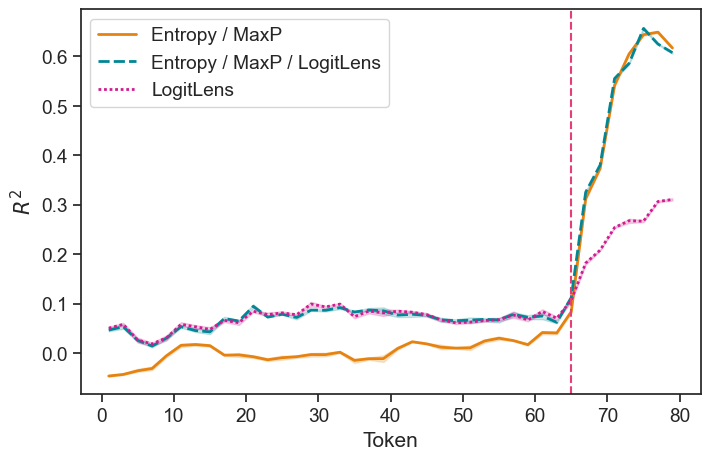

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.25)

from palettable.cartocolors.qualitative import Prism_10, Bold_10

plt.figure(figsize=(8, 5))

aucs_ = pd.concat([aucs_1, aucs_2, aucs_3], axis=0)

from scipy.ndimage import gaussian_filter1d
# aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

ax = sns.lineplot(aucs_, x='k', y='r2', hue='src', palette=Bold_10.mpl_colors[6:], linewidth = 2, style="src")
ax.set_title("")

ax.axvline(postilla_shift, color=Bold_10.mpl_colors[4], linestyle="--", label="prompt end")
# ax.axvline(postilla_shift + 10, color="navy", linestyle="--", label="prompt end")

plt.xlabel("Token")
plt.ylabel("$R^2$")


leg = plt.gca().get_legend()
leg.set_title(None)

plt.savefig('progressive_window_' + model_name_short + '.pdf', format="pdf", bbox_inches="tight", dpi=600)